In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from typing import Callable

In [7]:
class RBFLayer(nn.Module):
    """
    Defines a Radial Basis Function Layer

    An RBF is defined by 5 elements:
        1. A radial kernel phi
        2. A positive shape parameter epsilon
        3. The number of kernels N, and their relative
           centers c_i, i=1, ..., N
        4. A norm ||.||
        5. A set of weights w_i, i=1, ..., N

    The output of an RBF is given by
    y(x) = sum_{i=1}^N a_i * phi(eps_i * ||x - c_i||)

    For more information check [1,2]

    [1] https://en.wikipedia.org/wiki/Radial_basis_function
    [2] https://en.wikipedia.org/wiki/Radial_basis_function_network

    Parameters
    ----------
        in_features_dim: int
            Dimensionality of the input features
        num_kernels: int
            Number of kernels to use
        out_features_dim: int
            Dimensionality of the output features
        radial_function: Callable[[torch.Tensor], torch.Tensor]
            A radial basis function that returns a tensor of real values
            given a tensor of real values
        norm_function: Callable[[torch.Tensor], torch.Tensor]
            Normalization function applied on the features
        normalization: bool, optional
            if True applies the normalization trick to the rbf layer
        initial_shape_parameter: torch.Tensor, optional
            Sets the shape parameter to the desired value.
        initial_centers_parameter: torch.Tensor, optional
            Sets the centers to the desired value.
        initial_weights_parameters: torch.Tensor, optional
            Sets the weights parameter to the desired value.
        constant_shape_parameter: bool, optional
            Sets the shapes parameters to a non-learnable constant.
            initial_shape_parameter must be different than None if
            constant_shape_parameter is True
        constant_centers_parameter: bool, optional
            Sets the centers to a non-learnable constant.
            initial_centers_parameter must be different than None if
            constant_centers_parameter is True
        constant_weights_parameters: bool, optional
            Sets the weights to a non-learnable constant.
            initial_weights_parameters must be different than None if
            constant_weights_parameters is True
    """

    def __init__(self,
                 in_features_dim: int,
                 num_kernels: int,
                 out_features_dim: int,
                 radial_function: Callable[[torch.Tensor], torch.Tensor],
                 norm_function: Callable[[torch.Tensor], torch.Tensor],
                 normalization: bool = True,
                 initial_shape_parameter: torch.Tensor = None,
                 initial_centers_parameter: torch.Tensor = None,
                 initial_weights_parameters: torch.Tensor = None,
                 constant_shape_parameter: bool = False,
                 constant_centers_parameter: bool = False,
                 constant_weights_parameters: bool = False):
        super(RBFLayer, self).__init__()

        self.in_features_dim = in_features_dim
        self.num_kernels = num_kernels
        self.out_features_dim = out_features_dim
        self.radial_function = radial_function
        self.norm_function = norm_function
        self.normalization = normalization

        self.initial_shape_parameter = initial_shape_parameter
        self.constant_shape_parameter = constant_shape_parameter

        self.initial_centers_parameter = initial_centers_parameter
        self.constant_centers_parameter = constant_centers_parameter

        self.initial_weights_parameters = initial_weights_parameters
        self.constant_weights_parameters = constant_weights_parameters

        assert radial_function is not None  \
            and norm_function is not None
        assert normalization is False or normalization is True

        self._make_parameters()

    def _make_parameters(self) -> None:
        # Initialize linear combination weights
        if self.constant_weights_parameters:
            self.weights = nn.Parameter(
                self.initial_weights_parameters, requires_grad=False)
        else:
            self.weights = nn.Parameter(
                torch.zeros(
                    self.out_features_dim,
                    self.num_kernels,
                    dtype=torch.float32))

        # Initialize kernels' centers
        if self.constant_centers_parameter:
            self.kernels_centers = nn.Parameter(
                self.initial_centers_parameter, requires_grad=False)
        else:
            self.kernels_centers = nn.Parameter(
                torch.zeros(
                    self.num_kernels,
                    self.in_features_dim,
                    dtype=torch.float32))

        # Initialize shape parameter
        if self.constant_shape_parameter:
            self.log_shapes = nn.Parameter(
                self.initial_shape_parameter, requires_grad=False)
        else:
            self.log_shapes = nn.Parameter(
                torch.zeros(self.num_kernels, dtype=torch.float32))

        self.reset()

    def reset(self,
              upper_bound_kernels: float = 1.0,
              std_shapes: float = 0.1,
              gain_weights: float = 1.0) -> None:
        """
        Resets all the parameters.

        Parameters
        ----------
            upper_bound_kernels: float, optional
                Randomly samples the centers of the kernels from a uniform
                distribution U(-x, x) where x = upper_bound_kernels
            std_shapes: float, optional
                Randomly samples the log-shape parameters from a normal
                distribution with mean 0 and std std_shapes
            gain_weights: float, optional
                Randomly samples the weights used to linearly combine the
                output of the kernels from a xavier_uniform with gain
                equal to gain_weights
        """
        if self.initial_centers_parameter is None:
            nn.init.uniform_(
                self.kernels_centers,
                a=-upper_bound_kernels,
                b=upper_bound_kernels)

        if self.initial_shape_parameter is None:
            nn.init.normal_(self.log_shapes, mean=0.0, std=std_shapes)

        if self.initial_weights_parameters is None:
            nn.init.xavier_uniform_(self.weights, gain=gain_weights)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        """
        Computes the ouput of the RBF layer given an input vector

        Parameters
        ----------
            input: torch.Tensor
                Input tensor of size B x Fin, where B is the batch size,
                and Fin is the feature space dimensionality of the input

        Returns
        ----------
            out: torch.Tensor
                Output tensor of size B x Fout, where B is the batch
                size of the input, and Fout is the output feature space
                dimensionality
        """

        # Input has size B x Fin
        batch_size = input.size(0)

        # Compute difference from centers
        # c has size B x num_kernels x Fin
        c = self.kernels_centers.expand(batch_size, self.num_kernels,
                                        self.in_features_dim)

        diff = input.view(batch_size, 1, self.in_features_dim) - c

        # Apply norm function; c has size B x num_kernels
        r = self.norm_function(diff)

        # Apply parameter, eps_r has size B x num_kernels
        eps_r = self.log_shapes.exp().expand(batch_size, self.num_kernels) * r

        # Apply radial basis function; rbf has size B x num_kernels
        rbfs = self.radial_function(eps_r)

        # Apply normalization
        # (check https://en.wikipedia.org/wiki/Radial_basis_function_network)
        if self.normalization:
            # 1e-9 prevents division by 0
            rbfs = rbfs / (1e-9 + rbfs.sum(dim=-1)).unsqueeze(-1)

        # Take linear combination
        out = self.weights.expand(batch_size, self.out_features_dim,
                                  self.num_kernels) * rbfs.view(
                                      batch_size, 1, self.num_kernels)

        return out.sum(dim=-1)

    @property
    def get_kernels_centers(self):
        """ Returns the centers of the kernels """
        return self.kernels_centers.detach()

    @property
    def get_weights(self):
        """ Returns the linear combination weights """
        return self.weights.detach()

    @property
    def get_shapes(self):
        """ Returns the shape parameters """
        return self.log_shapes.detach().exp()

In [87]:
n_features = 1
n_kernels = 2
n_outputs = 1
n_samples = 100

In [88]:
rbf_layer = RBFLayer(
    in_features_dim=n_features,
    num_kernels=n_kernels,
    out_features_dim=n_outputs,
    radial_function=lambda x: torch.exp(-x**2),
    norm_function=lambda x: torch.norm(x, dim=-1),
    normalization=True
)

In [89]:
X = torch.normal(0, 1, (n_samples, n_features))

X.shape

true_function = lambda x : torch.sin(x * 3) + (torch.square(x))

y = true_function(X)[:, 0]

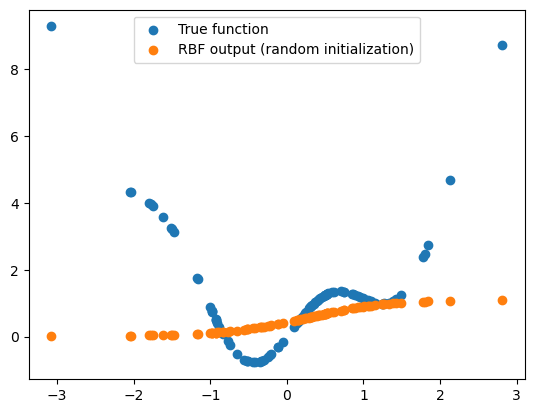

In [90]:
out = rbf_layer(X)

plt.scatter(X.detach().numpy()[:, 0], y.detach().numpy(), label='True function')  
plt.scatter(X.detach().numpy()[:, 0], out.detach().numpy()[:, 0], label='RBF output (random initialization)')
plt.legend()

In [91]:
losses = []

optimizer = torch.optim.Adam(rbf_layer.parameters(), lr=0.01)

for i in tqdm(range(1000)):
    y_hat = rbf_layer(X)[:, 0]

    loss = F.mse_loss(y_hat, y)

    loss.backward()

    optimizer.step()

    optimizer.zero_grad()

    losses.append(loss.item())

100%|██████████| 1000/1000 [00:00<00:00, 4033.95it/s]


Text(0, 0.5, 'MSE Loss')

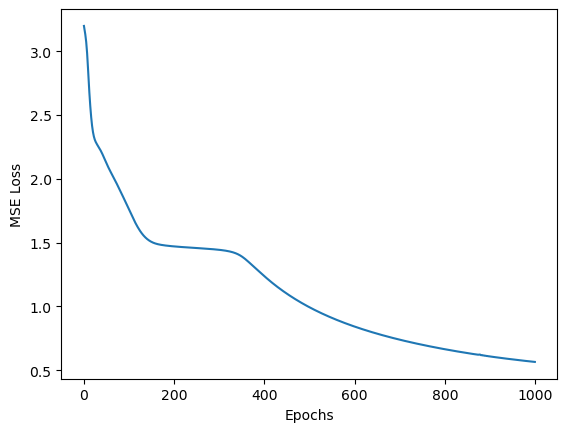

In [92]:
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')

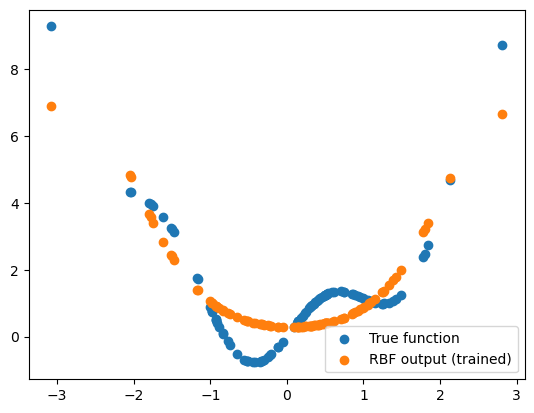

In [93]:
out = rbf_layer(X)

plt.scatter(X.detach().numpy()[:, 0], y.detach().numpy(), label='True function')  
plt.scatter(X.detach().numpy()[:, 0], out.detach().numpy()[:, 0], label='RBF output (trained)')
plt.legend()

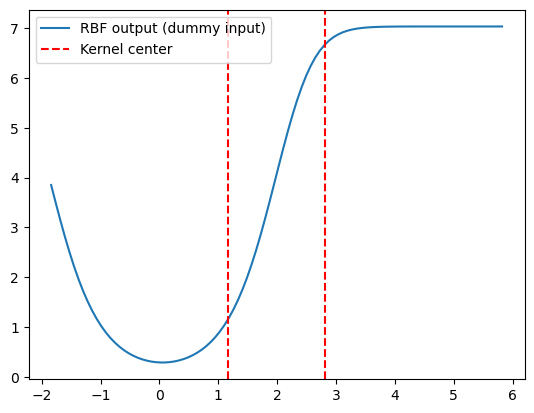

In [104]:
kernel_centers = rbf_layer.get_kernels_centers.flatten()  

dummy_in = torch.linspace(min(kernel_centers) - 3, max(kernel_centers) + 3, 100).view(-1, 1)
dummy_out = rbf_layer(dummy_in)

plt.plot(dummy_in.detach().numpy(), dummy_out.detach().numpy(), label='RBF output (dummy input)')

for i, kernel_center in enumerate(kernel_centers):
    plt.axvline(kernel_center.item(), color='r', linestyle='--', label='Kernel center' if i == 0 else None) 

plt.legend()